In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
env = gym.make("CartPole-v1") #("Pendulum-v0")
# observation = env.reset()
# for _ in range(100):
#     env.render()
#     action = env.action_space.sample() # your agent here (this takes random actions)
#     observation, reward, done, info = env.step(action)

#     if done:
#         observation = env.reset()
# env.close()

Reward
Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.

Starting State
    All observations are assigned a uniform random value between ±0.05.

Episode Termination

    Pole Angle is more than ±12°
    
    Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)

    Episode length is greater than 200 (500 for v1).

In [4]:
# space (0 => Push cart to the left, 1 => Push cart to the right), (cart pos, cart veloc, pole angle, pole veloc)
env.action_space, env.observation_space

(Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [5]:
class model(nn.Module):
    def __init__(self, input_units = 4, h_units = 32, out_units = 2):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(input_units, h_units),
            nn.ELU(),
            nn.Linear(h_units, h_units),
            nn.ELU(),
            nn.Linear(h_units, out_units)
        )
#         self.initialize_weights()
    def forward(self, x):
        x = self.l(x)
        return x
    
    # weight init my improve convergence speed
    def initialize_weights(self):
        for idx, m in enumerate(self.modules()): # will return modules and submodules
            if(isinstance(m, (nn.Linear))):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

In [6]:
def greedy(state):
    if(np.random.rand() < epsilon):
        action = np.random.randint(2)
    else:
        action = torch.argmax(network(torch.tensor(state, dtype = torch.float32)))
    return int(action)

In [7]:
def train_batch():
    states, actions, rewards, next_states, dones = sample_sarsa()
    q_values = network(torch.tensor(states, dtype = torch.float32))
    rewards = torch.tensor(rewards, dtype = torch.float32)[:, None]
    optimizer.zero_grad()
    next_q_vals = network(torch.tensor(next_states, dtype = torch.float32))

    next_mask = next_q_vals.argmax(1)[:, None]
    mask = torch.tensor(actions)[:, None]
    dones = torch.tensor(dones, dtype = torch.int32)[:, None]
    target = rewards + discount_rate * (1 - dones) * next_q_vals.gather(1, next_mask)
    loss = Loss(target, q_values.gather(1, mask))
    loss.backward()
    optimizer.step()

In [8]:
def sample_sarsa():
    indices = np.random.randint(0, len(replay_memory), size = batch_size)
    states, actions, rewards, next_states, dones = [[replay_memory[i][j] for i in indices] 
                                                                        for j in range(5)]
    return states, actions, rewards, next_states, dones

In [20]:
def action_step(state, action):
    next_state, reward, done, info = env.step(int(action))
    if(abs(next_state[0]) > dist_constaint):
        done = True
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, done

In [10]:
env.seed(42)
np.random.seed(42)

In [11]:
from collections import deque

que_size = 2000
replay_memory = deque(maxlen=que_size)

network = model()

In [13]:
mx = 0
n_episodes = 7000
lr = 0.001
discount_rate = 0.95
path = "model_" + "best" + ".pt"
dist_constaint = 0.5 # this is an additional constraint, if the distance from the middle is > 0.5 inches, terminates.

optimizer = torch.optim.Adam(network.parameters(), lr = lr)
Loss = nn.MSELoss()

batch_size = 32
rewards_list = []
path = ""
win_len = 25

for i in range(n_episodes):
    it = 0
    state = env.reset()
    action = np.random.randint(0, 2)
    for j in range(1000):
        epsilon = max(1 - i/500, 0.01)
        state, done = action_step(state, action)
        action = greedy(state)
        it += 1
        if(done):
            break
            
    rewards_list.append(it)
    if(i > 50):
        train_batch()
        
    mean_reward = sum(rewards_list[-win_len:])/min(len(rewards_list), win_len)
    if(mean_reward >= mx and mean_reward > 200):
        mx = mean_reward
        torch.save({
          'epoch': i,
          'model_state_dict': network.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'iterations': mean_reward,
          }, path)
    
    print("\rEpisode : {} eps : {:.3f}  Step : {} ".format(i, epsilon, it), end = "")

Episode : 6999 eps : 0.010  Step : 92  

In [14]:
def average_window(data, win_size):
    res = []
    for i in range(len(data) - win_size + 1):
        s = 0
        for j in range(i, i + win_size):
            s += data[j]
        res.append(s/win_size)
    return res

In [15]:
avg = average_window(rewards_list, 100)

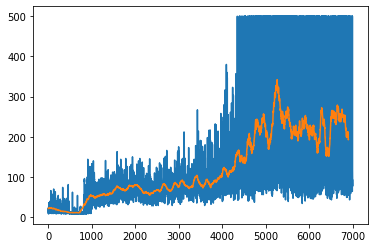

In [16]:
plt.plot(rewards_list)
plt.plot(avg)

In [17]:
network2 = model()
checkpoint = torch.load(path) # load the last best model
network2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# z = list(weights)
# for i, layer in enumerate(network2.parameters()):
# #     print(i, layer.size())
#     layer.data = z[i]

In [19]:
env.seed(42)
obs = env.reset()
done = False
total_rewards = 0

z = 0

with torch.no_grad():
    while(not done):
        if(np.random.rand() < 0.01):
            action = np.random.randint(0, 2)
        else:
            action = int(torch.argmax(network2(torch.tensor(obs, dtype = torch.float32))))
#         if(total_rewards < 15):
#             action = action = np.random.randint(0, 2)
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        env.render()
        if(abs(obs[0]) > 0.5):
            break
env.close()
print(total_rewards)

500.0
